<a href="https://colab.research.google.com/github/starovit/edu-fsdl-text-recognizer-2022-labs/blob/main/lab01/notebooks/hw_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [74]:
# 1 download MNIST

from pathlib import Path
import requests

def download_mnist(path):
  url = "https://github.com/pytorch/tutorials/raw/main/_static/"
  filename = "mnist.pkl.gz"

  Path(path).mkdir(parents=True, exist_ok=True)
  content = requests.get(url + filename).content
  with open(path / filename, 'wb') as file:
      file.write(content)

  return path / filename

path = Path("data/")
datafile = download_mnist(path)

In [104]:
# 2 read MNIST

import gzip
import pickle

def read_mnist(path):
    with gzip.open(path, "rb") as f:
        # ignore test
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")
    return x_train, y_train, x_valid, y_valid

x_train, y_train, x_valid, y_valid = read_mnist(datafile)

In [105]:
# 3 data to tensors

import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)

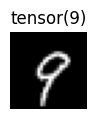

In [155]:
# 3 show random image

import random

def show_image(image: torch.Tensor, title: str):
  new_shape = (int(image.shape[0]**0.5), -1)
  image = image.reshape(new_shape)
  plt.figure(figsize=(1,1))
  plt.axis("off")
  plt.imshow(image, cmap="gray")
  plt.title(title)


index = random.randint(0, y_train.shape[0])
show_image(image = x_train[index], title = y_train[index])

In [264]:
def model(x: torch.Tensor) -> torch.Tensor:
  x = x @ weights + bias
  # x = torch.exp(x) / torch.sum(torch.exp(x), axis=1, keepdim=True)
  x = x - torch.log(torch.sum(torch.exp(x), axis=1))[:, None]
  return x

def accuracy(prediction: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    prediction = torch.argmax(prediction, dim=1)
    return (prediction == target).float().mean()

def cross_entropy(prediction: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
  return -prediction[range(target.shape[0]), target].mean()

In [266]:
epochs = 20
lr = 0.1

n = x_train.shape[0]
bs = 64

# initialization
weights = torch.randn(784, 10).requires_grad_()
bias = torch.randn(10).requires_grad_()
loss_func = cross_entropy

# learning loop
for epoch in range(epochs):
    for ii in range((n - 1) // bs + 1):
      # indexes
      start_idx = ii * bs
      end_idx = start_idx + bs

      # pull batches from x and from y
      xb = x_train[start_idx:end_idx]
      yb = y_train[start_idx:end_idx]

      # make prediction
      prediction = model(xb)
      loss = loss_func(prediction, yb)
      loss.backward()

      # update weights
      with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

    print(loss)
    print(f"epoch {epoch}: {accuracy(prediction, yb)}")

tensor(2.4106, grad_fn=<NegBackward0>)
epoch 0: 0.75
tensor(1.9393, grad_fn=<NegBackward0>)
epoch 1: 0.8125
tensor(1.6173, grad_fn=<NegBackward0>)
epoch 2: 0.8125
tensor(1.3673, grad_fn=<NegBackward0>)
epoch 3: 0.875
tensor(1.1597, grad_fn=<NegBackward0>)
epoch 4: 0.875
tensor(0.9839, grad_fn=<NegBackward0>)
epoch 5: 0.875
tensor(0.8348, grad_fn=<NegBackward0>)
epoch 6: 0.875
tensor(0.7085, grad_fn=<NegBackward0>)
epoch 7: 0.875
tensor(0.6024, grad_fn=<NegBackward0>)
epoch 8: 0.875
tensor(0.5142, grad_fn=<NegBackward0>)
epoch 9: 0.875
tensor(0.4422, grad_fn=<NegBackward0>)
epoch 10: 0.875
tensor(0.3846, grad_fn=<NegBackward0>)
epoch 11: 0.875
tensor(0.3392, grad_fn=<NegBackward0>)
epoch 12: 0.875
tensor(0.3036, grad_fn=<NegBackward0>)
epoch 13: 0.875
tensor(0.2756, grad_fn=<NegBackward0>)
epoch 14: 0.875
tensor(0.2534, grad_fn=<NegBackward0>)
epoch 15: 0.875
tensor(0.2356, grad_fn=<NegBackward0>)
epoch 16: 0.9375
tensor(0.2214, grad_fn=<NegBackward0>)
epoch 17: 0.9375
tensor(0.2097, gr

predicted: 7


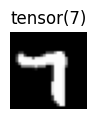

In [285]:
index = random.randint(0, y_train.shape[0])
show_image(image = x_train[index], title = y_train[index])

prediction = model(x_train[index][None, :]).argmax()
print(f"predicted: {prediction}")